In [1]:
import torch
import numpy as np
from sklearn.datasets import fetch_20newsgroups
import string
import re
from collections import Counter
import sys
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm, tqdm_notebook
from torch.optim import lr_scheduler
import torch.nn.functional as F
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer


C:\Python\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
newsgroups_train = fetch_20newsgroups(subset='train')

In [4]:
newsgroups_test = fetch_20newsgroups(subset='test')

In [5]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [6]:
X_tensor = tokenizer(newsgroups_train.data, padding=True, truncation=True, return_tensors="pt")
y_tensor = torch.tensor(np.array(newsgroups_train.target), dtype=torch.long)

In [7]:
X_t_tensor = tokenizer(newsgroups_test.data, padding=True, truncation=True, return_tensors="pt")
y_t_tensor = torch.tensor(np.array(newsgroups_test.target), dtype=torch.long)

In [8]:
input_ids = X_tensor['input_ids']
attention_mask = X_tensor['attention_mask']
dataset = TensorDataset(input_ids, attention_mask, y_tensor)

In [9]:
input_ids_test = X_t_tensor['input_ids']
attention_mask_test = X_t_tensor['attention_mask']
test_dataset = TensorDataset(input_ids_test, attention_mask_test, y_t_tensor)

In [10]:
class MyModel(nn.Module):
    def __init__(self, bert_model_name="bert-base-uncased", lstm_units=128,
                 dense_units=256, num_classes=20, nhead=4, num_layers=1, dropout=0.5):
        super(MyModel, self).__init__()
        
        self.bert = AutoModel.from_pretrained(bert_model_name)
        for param in self.bert.parameters():
            param.requires_grad = False
        
        bert_hidden_size = self.bert.config.hidden_size
        
        self.lstm = nn.LSTM(input_size=bert_hidden_size,
                            hidden_size=lstm_units,
                            batch_first=True,
                            bidirectional=True)
        
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=2*lstm_units,
                                                   nhead=nhead,
                                                   dim_feedforward=dense_units,
                                                   dropout=dropout,
                                                   batch_first=True)
        
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.dropout = nn.Dropout(dropout)
        
        self.fc = nn.Linear(2*lstm_units, dense_units)
        self.out = nn.Linear(dense_units, num_classes)
        
    def forward(self, input_ids, attention_mask=None):
        with torch.no_grad():  
            bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            x = bert_outputs.last_hidden_state  
            
        x, _ = self.lstm(x)  
        x = self.transformer(x)  
        
        x = x.mean(dim=1)  
        
        x = self.dropout(F.relu(self.fc(x)))
        x = self.out(x)
        
        return x


In [11]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for input_ids, attention_mask, labels in train_loader:
        input_ids = input_ids.to(DEVICE)
        attention_mask = attention_mask.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * input_ids.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += input_ids.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [12]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for input_ids, attention_mask, labels in val_loader:
        input_ids = input_ids.to(DEVICE)
        attention_mask = attention_mask.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * input_ids.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += input_ids.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [13]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    
    best_val_loss = float('inf')
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=1e-4) #AdamW вместо Adam
        #exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)  #меняем learning rate 
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), "best_model.pth") 
                tqdm.write(f"Best model saved at epoch {epoch+1} with val_loss={val_loss:.4f}")
                
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [14]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for input_ids, attention_mask in test_loader:
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            model.eval()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [15]:
DEVICE = torch.device("cuda")

In [16]:
model = MyModel().to(DEVICE)

In [17]:
history = train(dataset, test_dataset, model=model, epochs=5, batch_size=8)

epoch:   0%|                                                                                     | 0/5 [00:00<?, ?it/s]

loss 1.6630456611759064


epoch:  20%|██████████████▌                                                          | 1/5 [17:46<1:11:04, 1066.14s/it]

Best model saved at epoch 1 with val_loss=0.9122

Epoch 001 train_loss: 1.6630     val_loss 0.9122 train_acc 0.4718 val_acc 0.6873
loss 0.7460047332499165


epoch:  40%|██████████████████████████████                                             | 2/5 [35:27<53:09, 1063.12s/it]

Best model saved at epoch 2 with val_loss=0.7984

Epoch 002 train_loss: 0.7460     val_loss 0.7984 train_acc 0.7546 val_acc 0.7574
loss 0.5606311269885494


epoch:  60%|█████████████████████████████████████████████                              | 3/5 [53:05<35:21, 1060.72s/it]

Best model saved at epoch 3 with val_loss=0.7427

Epoch 003 train_loss: 0.5606     val_loss 0.7427 train_acc 0.8209 val_acc 0.7877
loss 0.4488927250925899


epoch:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [1:10:59<17:46, 1066.02s/it]


Epoch 004 train_loss: 0.4489     val_loss 0.7654 train_acc 0.8558 val_acc 0.7877
loss 0.3646454975833441


epoch: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [1:28:55<00:00, 1067.07s/it]


Epoch 005 train_loss: 0.3646     val_loss 0.7786 train_acc 0.8817 val_acc 0.8066


In [18]:
loss, acc, val_loss, val_acc = zip(*history)

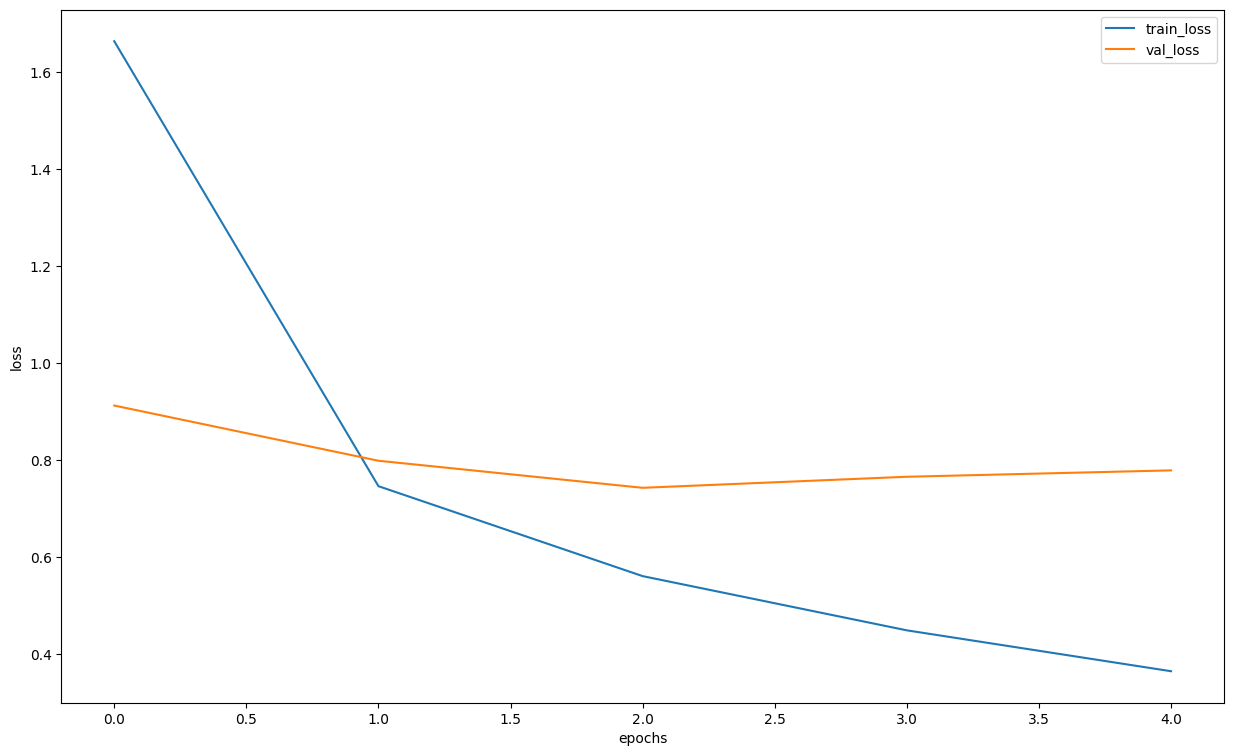

In [19]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()